In [9]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

TICKERS = ["AEP", "DUK", "SO", "ED", "EXC"]
PERIOD = "5y"

# ดึง exogenous ล่วงหน้า
EXOG_TICKERS = {
    "oil": "CL=F",
    "gas": "NG=F",
    "xlu": "XLU"
}


In [ ]:
def ensure_datetime_freq(series: pd.Series) -> pd.Series:
    s = series.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index()
    s = s.asfreq("B", method="ffill")  # ใช้ Business Day
    return s

def grid_search_arima(series, p_range=(0,4), d_range=(0,3), q_range=(0,4)):
    best_aic, best_order = np.inf, None
    for p,d,q in itertools.product(range(*p_range), range(*d_range), range(*q_range)):
        try:
            model = ARIMA(series, order=(p,d,q)).fit()
            if model.aic < best_aic:
                best_aic, best_order = model.aic, (p,d,q)
        except:
            continue
    return best_order, best_aic

def grid_search_sarima(series, m=12,
                       p_range=(0,3), d_range=(0,2), q_range=(0,3),
                       P_range=(0,2), D_range=(0,2), Q_range=(0,2)):
    best_aic, best_order, best_seasonal = np.inf, None, None
    for p,d,q in itertools.product(range(*p_range), range(*d_range), range(*q_range)):
        for P,D,Q in itertools.product(range(*P_range), range(*D_range), range(*Q_range)):
            try:
                model = SARIMAX(series, order=(p,d,q), seasonal_order=(P,D,Q,m),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
                if model.aic < best_aic:
                    best_aic, best_order, best_seasonal = model.aic, (p,d,q), (P,D,Q,m)
            except:
                continue
    return best_order, best_seasonal, best_aic

def grid_search_sarimax(series, exog, m=12,
                        p_range=(0,3), d_range=(0,2), q_range=(0,3),
                        P_range=(0,2), D_range=(0,2), Q_range=(0,2)):
    best_aic, best_order, best_seasonal = np.inf, None, None
    for p,d,q in itertools.product(range(*p_range), range(*d_range), range(*q_range)):
        for P,D,Q in itertools.product(range(*P_range), range(*D_range), range(*Q_range)):
            try:
                model = SARIMAX(series, order=(p,d,q), seasonal_order=(P,D,Q,m),
                                exog=exog,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
                if model.aic < best_aic:
                    best_aic, best_order, best_seasonal = model.aic, (p,d,q), (P,D,Q,m)
            except:
                continue
    return best_order, best_seasonal, best_aic


In [11]:
exog_all = pd.DataFrame()
for name, tkr in EXOG_TICKERS.items():
    s = yf.download(tkr, period=PERIOD, progress=False, auto_adjust=True)["Close"].dropna()
    s = ensure_datetime_freq(s)
    exog_all[name] = s

exog_all.tail()


,oil,gas,xlu
Date,,,
2025-09-17,64.050003,3.100,83.786011
2025-09-18,63.570000,2.939,83.845619
2025-09-19,62.680000,2.888,84.381996
2025-09-22,62.639999,2.806,85.199997
2025-09-23,62.880001,3.095,NaN


In [12]:
results = {}

for ticker in TICKERS:
    print(f"=== {ticker} ===")
    data = yf.download(ticker, period=PERIOD, progress=False, auto_adjust=True)["Close"].dropna()
    data = ensure_datetime_freq(data)
    
    # align exog
    exog = exog_all.reindex(data.index).ffill()
    
    # ARIMA
    best_arima, best_aic = grid_search_arima(data)
    print(f"ARIMA best: order={best_arima}, AIC={best_aic:.2f}")
    
    # SARIMA
    best_order_s, best_seasonal, best_aic_s = grid_search_sarima(data, m=12)
    print(f"SARIMA best: order={best_order_s}, seasonal={best_seasonal}, AIC={best_aic_s:.2f}")
    
    # SARIMAX
    best_order_x, best_seasonal_x, best_aic_x = grid_search_sarimax(data, exog=exog, m=12)
    print(f"SARIMAX best: order={best_order_x}, seasonal={best_seasonal_x}, AIC={best_aic_x:.2f}")
    
    results[ticker] = {
        "ARIMA": {"order": best_arima, "AIC": best_aic},
        "SARIMA": {"order": best_order_s, "seasonal_order": best_seasonal, "AIC": best_aic_s},
        "SARIMAX": {"order": best_order_x, "seasonal_order": best_seasonal_x, "AIC": best_aic_x}
    }
    print()


=== AEP ===


ValueError: too many values to unpack (expected 2)

In [ ]:
df_res = []
for sym, val in results.items():
    df_res.append([
        sym,
        val["ARIMA"]["order"], val["ARIMA"]["AIC"],
        val["SARIMA"]["order"], val["SARIMA"]["seasonal_order"], val["SARIMA"]["AIC"],
        val["SARIMAX"]["order"], val["SARIMAX"]["seasonal_order"], val["SARIMAX"]["AIC"]
    ])

res_df = pd.DataFrame(df_res, columns=[
    "Symbol",
    "ARIMA order","ARIMA AIC",
    "SARIMA order","SARIMA seasonal","SARIMA AIC",
    "SARIMAX order","SARIMAX seasonal","SARIMAX AIC"
])
display(res_df)


,Symbol,ARIMA order,ARIMA AIC,SARIMA order,SARIMA seasonal,SARIMA AIC,SARIMAX order,SARIMAX seasonal,SARIMAX AIC
0,AEP,"(2, 1, 3)",3769.804249,"(0, 1, 2)","(0, 0, 1, 12)",3732.069433,"(2, 1, 2)","(0, 0, 1, 12)",2350.285365
1,DUK,"(0, 1, 0)",3837.030840,"(0, 1, 2)","(0, 0, 1, 12)",3783.677577,"(2, 1, 2)","(1, 0, 1, 12)",2329.640879
2,SO,"(2, 1, 0)",3049.263573,"(0, 1, 2)","(0, 0, 1, 12)",3023.494485,"(0, 1, 2)","(0, 0, 1, 12)",1623.836749
3,ED,"(0, 1, 0)",3659.315408,"(0, 1, 2)","(0, 0, 1, 12)",3629.256916,"(0, 1, 0)","(0, 0, 1, 12)",2451.179904
4,EXC,"(0, 1, 0)",1720.147357,"(0, 1, 1)","(0, 0, 1, 12)",1708.519689,"(0, 1, 1)","(0, 0, 1, 12)",552.918345


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


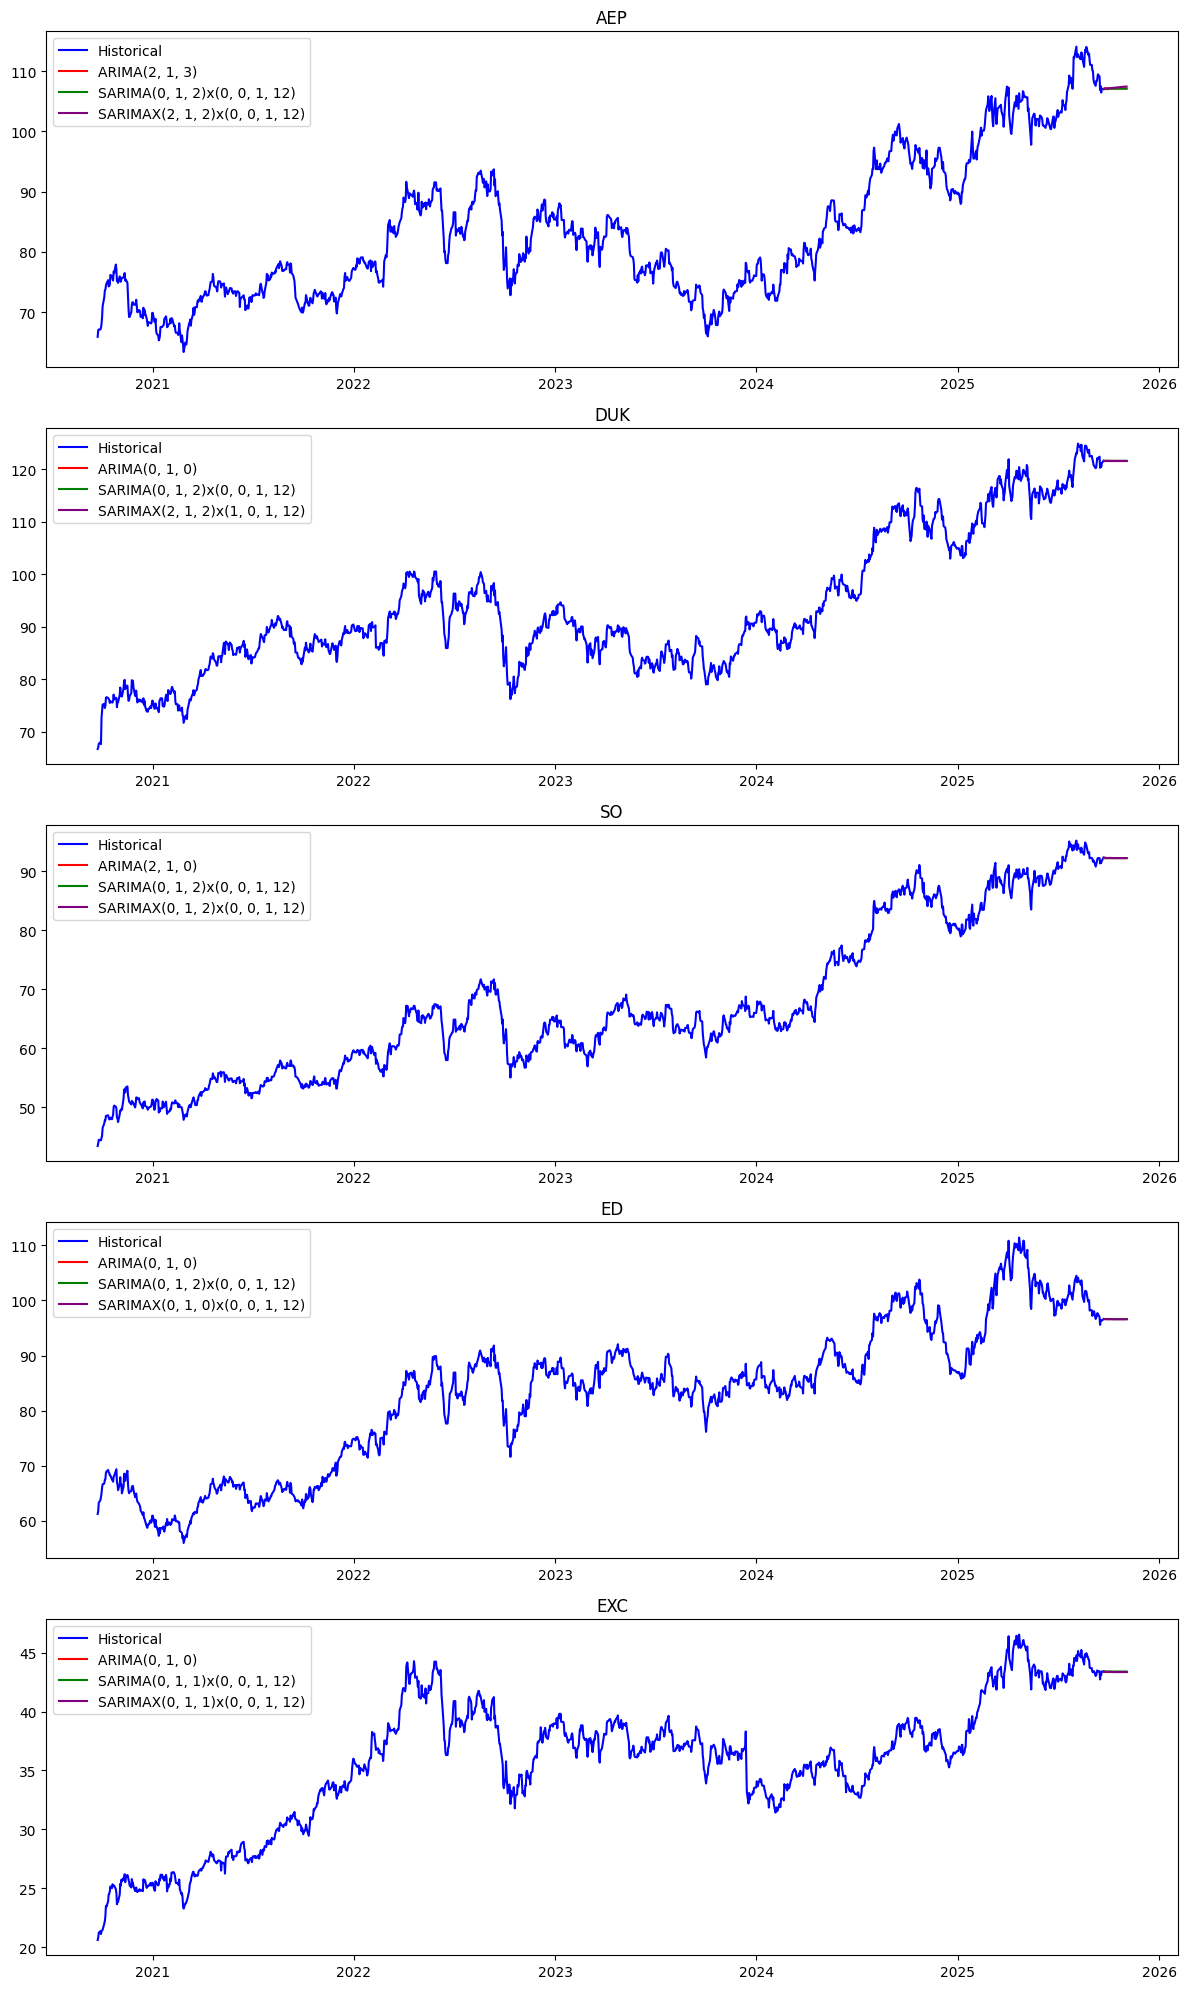

In [ ]:
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(12, 4*len(TICKERS)))

if len(TICKERS) == 1:
    axes = [axes]

for i, ticker in enumerate(TICKERS):
    data = yf.download(ticker, period=PERIOD, progress=False, auto_adjust=True)["Close"].dropna()
    data = ensure_datetime_freq(data)

    # Align exogenous สำหรับ SARIMAX
    exog = exog_all.reindex(data.index).ffill()

    # --- ARIMA ---
    order_a = results[ticker]["ARIMA"]["order"]
    model_a = ARIMA(data, order=order_a).fit()
    forecast_a = model_a.forecast(steps=30)

    # --- SARIMA ---
    order_s = results[ticker]["SARIMA"]["order"]
    seas_s  = results[ticker]["SARIMA"]["seasonal_order"]
    model_s = SARIMAX(data, order=order_s, seasonal_order=seas_s,
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)
    forecast_s = model_s.forecast(steps=30)

    # --- SARIMAX ---
    order_x = results[ticker]["SARIMAX"]["order"]
    seas_x  = results[ticker]["SARIMAX"]["seasonal_order"]
    model_x = SARIMAX(data, order=order_x, seasonal_order=seas_x,
                      exog=exog, enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)
    # exogenous future: ใช้ค่าล่าสุดซ้ำ
    exog_future = pd.DataFrame([exog.iloc[-1].values]*30,
                               columns=exog.columns,
                               index=pd.date_range(data.index[-1]+pd.Timedelta(days=1),
                                                   periods=30, freq="B"))
    forecast_x = model_x.forecast(steps=30, exog=exog_future)

    # --- Plot ---
    axes[i].plot(data.index, data, label="Historical", color="blue")
    axes[i].plot(forecast_a.index, forecast_a, label=f"ARIMA{order_a}", color="red")
    axes[i].plot(forecast_s.index, forecast_s, label=f"SARIMA{order_s}x{seas_s}", color="green")
    axes[i].plot(forecast_x.index, forecast_x, label=f"SARIMAX{order_x}x{seas_x}", color="purple")

    axes[i].set_title(ticker)
    axes[i].legend()

plt.tight_layout()
plt.show()
